In the [previous post]({% post_url 2020-05-28-gym %}) we were given an introduction to the OpenAI Gym library and API which is used very often in the research community. We also spent some time re-implementing $Q$-learning to solve the `FrozenLake-v0` task. 

We used dynamic programming to directly estimate values for $Q(s_t, a_t)$ for every possible state-action pair $(s_t, a_t)$. This is possible in `FrozenLake-v0` because there are only 16 states and 4 actions for a total of 64 state-action pairs. With sufficiently many timesteps, we will visit every state-action pair enough times to get a good estimate for their $Q$-value. 

However, it is rare that an environment has both a small, discrete action space $\mathcal{A}$ and a small discrete state space $\mathcal{S}$. It is instead often the case that one or both of these things are **continuous**. 

In reinforcement learning, **continuous action spaces** represent the agent's actions $a_t$ as a real-valued tensor (usually a vector). For example, in the `BipedalWalker-v3` environment, the action space consists of a subset of vectors in $\mathbb{R}^4$ corresponding to torque applied to joints of a robot. The corresponding OpenAI Gym type is a `Box` action space.

In [1]:
import gym

In [2]:
env = gym.make("BipedalWalker-v3")

/opt/tljh/user/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
env.action_space

Box(4,)

Similarly, **continuous observation spaces** represent an agent's observations of the state $s_t$ as a real-valued tensor. Continuous observation spaces arise most commonly in two scenarios:
1. The observations correspond to a set of real-valued measurements (such as joint angles, speed, etc), in which case the observations are usually real-valued vectors
2. The observations correspond to images/visual input, in which case the observations are usually real-valued 3D tensors (height $\times$ width $\times$ channels).

The `BipedalWalker-v3` environment has a continuous observation space consisting of a subset of vectors in $\mathbb{R}^{24}$ corresponding to various pieces of information about the robot's body.

In [4]:
env.observation_space

Box(24,)

In **model-free** reinforcement learning, the agent does not necessarily learn a model of the dynamics of the environment, it just directly learns a policy $\pi$ that maximizes the expected discounted return. One advantage of model-free reinforcement learning is that the agent does not have to actually know or understand what any of the observations or actions "mean". It just needs to learn a good mapping from states to actions.

The original formulation of $Q$-learning requires that both the state and action space be small and discrete. However, we run into problems when the action space or observation space (or both!) are continuous.

Say we have an observation space like that of `BipedalWalker-v3`, with 24 dimensions. We could try to discretize the observation space by binning each dimension into 3 ranges of values, but we would still end up with $3^{24} = 282,429,536,481$ states. The $Q$-learning algorithm converges as we see more state-action pairs, but with this many states, it becomes intractable to use. Furthermore, what happens if the action space is also continuous? Clearly the discretizing approach is not appropriate.

Let's develop an algorithm based on $Q$-learning that can handle discrete action spaces and continuous observation spaces.

First, let's think of $Q^\pi$ as being a function over state-action pairs $(s_t, a_t)$ of the form $\mathcal{S} \times \mathcal{A} \to \mathbb{R}$. Since the action space is discrete, let's instead think of $Q^\pi$ as consisting of $\lvert \mathcal{A} \rvert$ different functions of the form $\mathcal{S} \to \mathbb{R}$.

Let's assume that each $Q^\pi(\cdot, a_t)$ is a **continuous** function over $\mathcal{S}$. This means that given two similar states $s \approx s'$ we should also have $Q^\pi(s, a) \approx Q^\pi(s', a)$ for a given $a$. This is a reasonable assumption; if two states are similar, then they should be similarly good (or similarly bad). 

We can fit each $Q^\pi(\cdot, a_t)$ via **regression** using a **differentiable function approximator** $Q_\theta$ with learnable parameters $\theta$. The most common approach is to use a **neural network** with $\lvert \mathcal{A} \rvert$ output nodes, each corresponding to $Q_\theta(s_t, a_t)$ for each action $a_t$. 

![dqn.png](dqn.png)

Then, given a transition $(s_t, a_t, r_t, d_t, s_{t+1})$, we can minimize the squared error

$$
L(\theta) = \left(Q_\theta(s_t, a_t) - y \right)^2
$$

where the target $y$ is given by

$$
y = r_t + (1-d_t) \gamma \max_{a_{t+1}}Q_\theta(s_{t+1}, a_{t+1})
$$

We then minimize this loss with respect to $\theta$, treating $y$ as a constant. Minimizing this loss using stochastic gradient descent is equivalent to the $Q$-learning update rule that we used last in the previous posts.

The result is that over time, we improve our estimates for $Q^\pi(s_t, a_t)$ as we see more data. Furthermore, since $Q^\pi$ is continuous and since $Q_\theta$ is differentiable (and thus continuous), we *also* improve our estimates for nearby states $s_t'$. This allows us to generalize about values of $Q^\pi$ for states that we have not seen before, but that are close by to our training data.

In our original algorithm for $Q$-learning, the agent always uses the most recent transition $(s_t, a_t, r_t, s_{t+1}, d_t)$ to update its estimate for $Q^\pi$. However, this is only feasible since each parameters $Q(s_t, a_t)$ is independent of every other parameter, so updating one parameter has no effect on other parameters.

This changes when we use a neural network $Q_\theta$. Updating the parameters $\theta$ with respect to the loss function via gradient descent

$$
\theta \gets \theta - \alpha \nabla_\theta L(\theta)
$$

changes the parameters $\theta$, which in turn impacts our predictions for other state-action pairs. 

This is especially a problem since in most MDPs with continuous action spaces, the next state $s_{t+1}$ is usually quite similar to the current state $s_t$. Consider the following sequence of events:
1. You are in a state $s_t$
2. You choose an action $a_t \sim \pi(\cdot \mid s_t)$
3. You transition to a state $s_{t+1}$ with reward $r_t$ and terminal flag $d_t$
4. You update $\theta$ so that $Q_\theta(s_t, a_t)$ is closer to $r_t + (1-d_t) \gamma \max_{a_{t+1}} Q_\theta (s_{t+1}, a_{t+1})$

Let's say that we modify $\theta$ so that our estimate is a higher value than it was before. We are now in a state $s_{t+1}$, which is similar to the state $s_t$. Our estimate $Q_\theta(s_{t+1}, a_{t+1})$ is now higher due to the update, which will in turn influence our prediction for the *next* state as well. We get a runaway effect by bootstrapping our target values $y$ from our own network $Q_\theta$ that leads to uncontrollably growing predictions for $Q_\theta(s_t, a_t)$. We call this kind of training **unstable**.

There are two easy ways to mitigate this that were developed by the authors of the [original paper](https://www.nature.com/articles/nature14236) on deep $Q$-learning: **replay buffers** and **target networks**.

A **replay buffer** $\mathcal{D}$ is just an array of transitions $(s_t, a_t, r_t, s_{t+1}, d_t)$ that we store while traversing the MDP. Then at each timestep, instead of updating $\theta$ according to the most recent transition, we instead sample a **batch** of training data from the buffer and use that instead. Replay buffers can be used to mitigate **catastrophic forgetting**. This is a phenomenon where updating $\theta$ to minimize the loss $L(\theta)$ decreases the loss on the current training examples, but actually increases the loss on older training examples, effectively unlearning what the network learned in the past.

In [5]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, batch_size=32, size=1000000):
        '''
        batch_size (int): number of data points per batch
        size (int): size of replay buffer.
        '''
        self.batch_size = batch_size
        self.memory = deque(maxlen=size)
        
    def remember(self, s_t, a_t, r_t, s_t_next, d_t):
        '''
        s_t (np.ndarray double): state
        a_t (np.ndarray int): action
        r_t (np.ndarray double): reward
        d_t (np.ndarray float): done flag
        s_t_next (np.ndarray double): next state
        '''
        self.memory.append((s_t, a_t, r_t, s_t_next, d_t))
        
    def sample(self):
        '''
        random sampling of data from buffer
        '''
        # if we don't have enough samples yet
        size = min(self.batch_size, len(self.memory))
        return random.sample(self.memory, size)

Another way to reduce the runaway effect of bootstrapping targets from our own network $Q_\theta$ is to use a **target network** $Q_\theta^-$ which is initially an identical copy of $Q_\theta$. The target network is only used to generate the target values $y$, and its paramaters are synchronized to match $Q_\theta$ on a fixed schedule of every $n_\theta$ timesteps. Since the parameters of $Q_\theta^-$ are frozen during training, updating $Q_\theta$ does not in turn impact our targets.

To make our deep $Q$-learning algorithm really good, we need to add in two more ingredients: **vectorized environments** and **epsilon decay**.

Up until this point, we have been treating our OpenAI Gym environments as a single MDP. However, when using a neural network, the time to perform inference (the forward pass through the network) is generally much longer than the time to step the environment. We can accelerate training time by using a **vectorized environment**, which essentially makes multiple copies of the same environment. Our observations $s_t$ become a **vector** of observations from the original state space $\mathcal{S}$ and our actions $a_t$ become a vector of actions from the original action space $\mathcal{A}$.

We can easily make an environment into a vectorized environment by making use of OpenAI Gym's `gym.Wrapper` class, which allows us to "wrap" an environment in a class to make it compatible with the Gym API.

To do this, we will make a `VectorizedEnvWrapper` class that accepts a `gym.Env` and makes copies of it.

Technically this is an incomplete class, since we should override the `env.action_space` and `env.observation_space` appropriately. However, in this case, we will implement only what we need. In this same vein, we will omit returning `info` from `env.step` since we do not need it.

In [6]:
import copy

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, env, num_envs=1):
        '''
        env (gym.Env): to make copies of
        num_envs (int): number of copies
        '''
        super().__init__(env)
        self.num_envs = num_envs
        self.envs = [copy.deepcopy(env) for n in range(num_envs)]
    
    def reset(self):
        '''
        Return and reset each environment
        '''
        return np.asarray([env.reset() for env in self.envs])
    
    def step(self, actions):
        '''
        Take a step in the environment and return the result.
        actions (np.ndarray int)
        '''
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, _ = env.step(action)
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

The class accepts and returns `np.ndarray`s for actions, states, rewards, and done flags. 

Since some `env`s in the vectorized env will be "done" before others, we automatically reset envs in our `step` function.

Vectorizing an environment is cheap. We might think of neural networks as taking input vectors and producing output vectors, but since internally all of the operations are matrix operations, we can just pass in a matrix as an input and produce a matrix as an output. By vectorizing the states that we input to the network, we automatically get vectorized actions as the output. It costs marginally more to take in 32 state and produce 32 action than to take in 1 state and produce 1 action.

The second ingredient to improving our agent is using **epsilon decay**. In the previous post we had a fixed value of $\epsilon$ for the entire training period (and turned it off during testing). When using epsilon decay we begin with a high initial value of $\epsilon$ labelled $\epsilon_i$ and linearly anneal $\epsilon$ towards a final value of $\epsilon_f$. We do this over a proportion $n_\epsilon$ of timestep (often taking $n_\epsilon = 0.1$). The point is that at the beginning of training, we should follow essentially random actions ($\epsilon \approx 1$) and by the time we are more confident with our learning, we should follow a greedy policy ($\epsilon \approx 0$).

Below we implement an agent that combines all of the above ingredients. We use `torch.nn.Sequential` to define a simple neural network `Q` representing $Q_\theta$. We use `copy.deepcopy` to make the target network `Q_` representing $Q_\theta^-$. 

In [7]:
import torch
import numpy as np

In [8]:
class DeepQLearner:
    def __init__(self, env, 
                 alpha=0.001, gamma=0.95, 
                 epsilon_i=1.0, epsilon_f=0.00, n_epsilon=0.1):
        '''
        env (VectorizedEnvWrapper): the vectorized gym.Env
        alpha (float): learning rate
        gamma (float): discount factor
        epsilon_i (float): initial value for epsilon
        epsilon_f (float): final value for epsilon
        n_epsilon (float): proportion of timesteps over which to
                           decay epsilon from epsilon_i to
                           epsilon_f
        '''
        
        self.num_envs = env.num_envs
        self.M = env.action_space.n  # number of actions
        self.N = env.observation_space.shape[0] # dimensionality of state space
        
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.gamma = gamma

        self.Q = torch.nn.Sequential(
            torch.nn.Linear(self.N, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, self.M)
        ).double()
        
        self.Q_ = copy.deepcopy(self.Q)
        
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=alpha)
    
    def synchronize(self):
        '''
        Used to make the parameters of Q_ match with Q.
        '''
        self.Q_.load_state_dict(self.Q.state_dict())

    def act(self, s_t):
        '''
        Epsilon-greedy policy.
        s_t (np.ndarray): the current state.
        '''
        s_t = torch.as_tensor(s_t).double()
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.M, size=self.num_envs)
        else:
            with torch.no_grad():
                return np.argmax(self.Q(s_t).numpy(), axis=1)
    
    def decay_epsilon(self, n):
        '''
        Epsilon decay.
        n (int): proportion of training complete
        '''
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, s_t, a_t, r_t, s_t_next, d_t):
        '''
        Learning step.
        s_t (np.ndarray double): state
        a_t (np.ndarray int): action
        r_t (np.ndarray double): reward
        d_t (np.ndarray float): done flag
        s_t_next (np.ndarray double): next state
        '''
        
        # make sure everything is torch.Tensor and type-compatible with Q
        s_t = torch.as_tensor(s_t).double()
        a_t = torch.as_tensor(a_t).long()
        r_t = torch.as_tensor(r_t).double()
        s_t_next = torch.as_tensor(s_t_next).double()
        d_t = torch.as_tensor(d_t).double()
        
        # we don't want gradients when calculating the target y
        with torch.no_grad():
            # taking 0th element because torch.max returns both maximum
            # and argmax
            Q_next = torch.max(self.Q_(s_t_next), dim=1)[0]
            target = r_t + (1-d_t)*self.gamma*Q_next
        
        # use advanced indexing on the return to get the predicted
        # Q values corresponding to the actions chosen in each environment.
        Q_pred = self.Q(s_t)[range(self.num_envs), a_t]
        loss = torch.mean((target - Q_pred)**2)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Finally, below we implement a training loop for this agent. It is more complex than the $Q$-learning training loop from the previous post, since we need to add a few lines for synchronizing $Q_\theta$ and $Q_\theta^-$.

In [9]:
def train(env, agent, replay_buffer, T=20000, n_theta=100):
    '''
    env (VectorizedEnvWrapper): vectorized gym.Env
    agent (DeepQLearner)
    buffer (ReplayBuffer)
    T (int): total number of training timesteps
    batch_size: number of 
    '''
    
    # for plotting
    returns = []
    episode_rewards = 0
    
    s_t = env.reset()
    for t in range(T):
        # synchronize Q and Q_
        if t%n_theta == 0:
            agent.synchronize()
        
        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)
        
        # store data into replay buffer
        replay_buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        s_t = s_t_next
        
        # learn by sampling from replay buffer
        for batch in replay_buffer.sample():
            agent.update(*batch)
            
        # for plotting
        episode_rewards += r_t
        for i in range(env.num_envs):
            if d_t[i]:
                returns.append(episode_rewards[i])
                episode_rewards[i] = 0
                
        # epsilon decay
        agent.decay_epsilon(t/T)
       
    plot_returns(returns)
    return agent

We will also keep track of the return $R_t$ for each environment in the vectorized environment, and then plot the return from those environments over time to illustrate the agent's learning process. We will use a rolling mean over time for plotting, since the $Q$-learning process can be kind of noisy.

In [10]:
import pandas as pd
import seaborn as sns; sns.set()

In [11]:
def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

Let's train this agent with deep $Q$-learning!

CPU times: user 14min 33s, sys: 5.68 s, total: 14min 38s
Wall time: 43.1 s


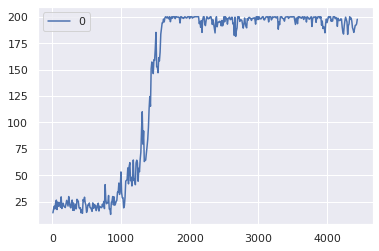

In [12]:
%%time

env = VectorizedEnvWrapper(gym.make("CartPole-v0"), num_envs=32)
agent = DeepQLearner(env, alpha=1e-3, gamma=0.95)
replay_buffer = ReplayBuffer(batch_size=1)
agent = train(env, agent, replay_buffer, T=20000)

This algorithm has a lot of hyperparameters, and these hyperparameters are the ones that I've found to give the best tradeoff between learning stability, performance, and compute time. Also note that this code is written to run on the CPU. The overhead of converting back and forth from `np.ndarray` to CUDA tensors takes supercedes any gains from using a GPU.

I hope that you enjoyed this post! You can download the notebook [here]().